Importar librerías necesarias

In [80]:
# Importación de librerías
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score,
    roc_curve, auc, accuracy_score 
)
from google.cloud import storage


In [131]:
# Establecer la ruta del archivo de credenciales
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../../cloud/proyecto2-462217-118002bf0caf.json"

In [132]:
# Parámetros de conexión a Google Cloud Storage
bucket_name = "mi-bucket-heartdata"
blob_path = "data/heart-disease-dataset.csv"
file_path = f"gs://{bucket_name}/{blob_path}"

In [137]:
df = pd.read_csv(file_path)

In [5]:
df.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,target
0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0,0.0,1.0,0.0
1,49.0,0.0,3.0,160.0,180.0,0.0,0.0,156.0,0.0,1.0,2.0,1.0
2,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0,0.0,1.0,0.0
3,48.0,0.0,4.0,138.0,214.0,0.0,0.0,108.0,1.0,1.5,2.0,1.0
4,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0,0.0,1.0,0.0


In [6]:
df.shape

(1190, 12)

Eliminamos datos duplicados

In [138]:
df = df.drop_duplicates()

In [8]:
df.shape

(918, 12)

Eliminamos outliers

In [139]:
# Filtrado de outliers basado en rangos definidos
df_clean = df[
    (df['age'] >= 18) & (df['age'] <= 100) &
    (df['resting_bp_s'] >= 90) & (df['resting_bp_s'] <= 210) &
    (df['cholesterol'] >= 100) & (df['cholesterol'] <= 700) &
    (df['max_heart_rate'] >= 60) & (df['max_heart_rate'] <= 220) &
    (df['oldpeak'] >= 0) & (df['oldpeak'] <= 6)
].copy()

In [10]:
df_clean.shape

(743, 12)

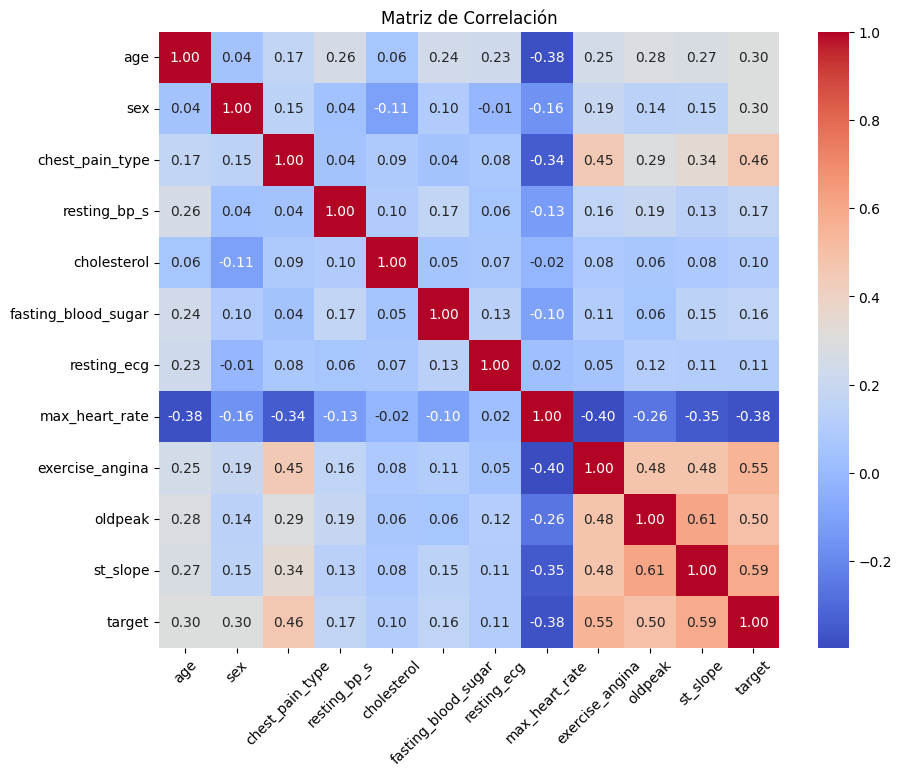

In [18]:
# Matriz de correlación
correlation_matrix = df_clean.corr(numeric_only=True)

# Mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45)
plt.title("Matriz de Correlación")
plt.show()

Teniendo en cuenta que el objetivo es la detección temprana de la enfermedad, 
decidimos eliminar variables que solo están disponibles tras pruebas clínicas avanzadas:
* exercise_angina	- Derivado de una prueba de esfuerzo. Se hace típicamente después de sospechas clínicas.
* oldpeak		- Resultado de electrocardiograma bajo estrés físico (post-evaluación inicial).
* st_slope	- Derivado directo de oldpeak. Involucra interpretación de prueba de esfuerzo.

| Variable                                                            | ¿Riesgo de Fuga? | Comentario                                                                                                             |
| ------------------------------------------------------------------- | ---------------- | ---------------------------------------------------------------------------------------------------------------------- |
| `age`, `sex`                                                        | ❌ No             | Datos demográficos seguros.                                                                                            |
| `chest_pain_type`                                                   | ⚠️ Bajo          | Síntoma subjetivo, pero válido clínicamente como predictor temprano.                                                   |
| `resting_bp_s`, `cholesterol`, `fasting_blood_sugar`, `resting_ecg` | ❌ No             | Datos de ingreso médico, seguros.                                                                                      |
| `max_heart_rate`                                                    | ⚠️ Posible       | Obtenido durante una prueba de esfuerzo, pero a veces se considera como parte de una evaluación inicial. Riesgo medio. |
| `exercise_angina`                                                   | ✅ Sí             | Derivado de una prueba de esfuerzo. Se hace típicamente después de sospechas clínicas.                                 |
| `oldpeak`                                                           | ✅ Sí             | Resultado de electrocardiograma bajo estrés físico (post-evaluación inicial).                                          |
| `st_slope`                                                          | ✅ Sí             | Derivado directo de `oldpeak`. Involucra interpretación de prueba de esfuerzo.                                         |


In [142]:
df_heart = df_clean.copy()

# Limpiar columnas no deseadas
df_heart.drop(columns=['exercise_angina', 'oldpeak', 'st_slope'], inplace=True)

df_heart.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,target
0,40.0,1.0,2.0,140.0,289.0,0.0,0.0,172.0,0.0
1,49.0,0.0,3.0,160.0,180.0,0.0,0.0,156.0,1.0
2,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0
3,48.0,0.0,4.0,138.0,214.0,0.0,0.0,108.0,1.0
4,54.0,1.0,3.0,150.0,195.0,0.0,0.0,122.0,0.0


In [143]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 743 entries, 0 to 1189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  743 non-null    float64
 1   sex                  743 non-null    float64
 2   chest_pain_type      743 non-null    float64
 3   resting_bp_s         743 non-null    float64
 4   cholesterol          743 non-null    float64
 5   fasting_blood_sugar  743 non-null    float64
 6   resting_ecg          743 non-null    float64
 7   max_heart_rate       743 non-null    float64
 8   target               743 non-null    float64
dtypes: float64(9)
memory usage: 58.0 KB


In [96]:
# Detectar columnas categóricas con menos de 10 valores únicos
categorical_cols = [col for col in df_heart.columns if df_heart[col].nunique() <= 10]
categorical_cols

['sex', 'chest_pain_type', 'fasting_blood_sugar', 'resting_ecg', 'target']

In [97]:
# Mostrar distribución porcentual de cada categoría
for col in categorical_cols:
    print(df_heart[col].value_counts(normalize=True).mul(100).round(1))


sex
1.0    75.6
0.0    24.4
Name: proportion, dtype: float64
chest_pain_type
4.0    49.5
3.0    22.6
2.0    22.3
1.0     5.5
Name: proportion, dtype: float64
fasting_blood_sugar
0.0    83.2
1.0    16.8
Name: proportion, dtype: float64
resting_ecg
0.0    59.8
2.0    23.6
1.0    16.7
Name: proportion, dtype: float64
target
0.0    52.2
1.0    47.8
Name: proportion, dtype: float64


2 - Preparación de datos Train y Test 

In [24]:
# Separar features y target
X = df_heart.drop('target', axis=1)
y = df_heart['target']

In [25]:
# Escalar datos y dividir en entrenamiento/test
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


3 – Definir modelos y GridSearch

In [ ]:
# Definir modelos a comparar y sus grids de hiperparámetros
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.5, 1.0]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 150],
            "learning_rate": [0.1, 0.05],
            "max_depth": [3, 5]
        }
    }
}


4 – Ejecutar GridSearch y guardar resultados

In [27]:
# Entrenar y comparar modelos con GridSearchCV de forma robusta
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix

rows = []

for name, mp in models_params.items():
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    # Convertir temporalmente para la evaluación
    y_test_int = y_test.astype(int)
    y_pred_int = y_pred.astype(int)

    report = classification_report(y_test_int, y_pred_int, output_dict=True)

    # report = classification_report(y_test, y_pred, output_dict=True)

    # Print Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(f"{name} → Matriz de confusión:")
    print(cm)

    # Acceder a métricas de la clase positiva (1), usando .get por seguridad
    class_1_metrics = report.get("1", {"precision": 0, "recall": 0, "f1-score": 0})
    
    rows.append({
        "Model": name,
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Accuracy": report["accuracy"],
        "Precision": class_1_metrics["precision"],
        "Recall": class_1_metrics["recall"],
        "F1-Score": class_1_metrics["f1-score"],
        "Best Params": grid.best_params_
    })

# Crear DataFrame con resultados
results_df = pd.DataFrame(rows)


Random Forest → Matriz de confusión:
[[53 22]
 [19 55]]
AdaBoost → Matriz de confusión:
[[56 19]
 [19 55]]
Gradient Boosting → Matriz de confusión:
[[53 22]
 [13 61]]


In [28]:
# Detectar carpeta actual y raíz del proyecto
current_dir = Path(os.getcwd())
project_root = current_dir.parent.parent

In [29]:
# Asegurarse de que exista la carpeta 'results'
output_path = project_root / "scripts" / "results"
output_path.mkdir(parents=True, exist_ok=True)

# Guardar resultados
results_df.to_csv(output_path / "model_comparison_results.csv", index=False)
print("Archivo guardado en: /scripts/results/model_comparison_results.csv")

Archivo guardado en: /scripts/results/model_comparison_results.csv


#### Subida de fichero model_comparison_results.csv al bucket de GCP.

In [276]:
def upload_csv_to_bucket(bucket_name, source_file_path, destination_blob_name):
    """
    Sube un archivo CSV a un bucket de GCP.

    bucket_name: nombre del bucket (str)
    source_file_path: ruta local del archivo CSV (str)
    destination_blob_name: nombre con el que se guardará en el bucket (str)
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_path)

    print(f"Archivo {source_file_path} subido a gs://{bucket_name}/{destination_blob_name}")

In [26]:
upload_csv_to_bucket(
    bucket_name="mi-bucket-heartdata",
    source_file_path="../../scripts/results/model_comparison_results.csv",
    destination_blob_name="scripts/results/model_comparison_results.csv"
)

Archivo ../../scripts/results/model_comparison_results.csv subido a gs://mi-bucket-heartdata/scripts/results/model_comparison_results.csv


#### Resultados de los Modelos utilizados - Random Forest, AdaBoost, Gradient Boosting 

In [40]:
print(results_df)

               Model   ROC AUC  Accuracy  Precision    Recall  F1-Score  \
0      Random Forest  0.814595  0.724832   0.714286  0.743243  0.728477   
1           AdaBoost  0.783514  0.744966   0.743243  0.743243  0.743243   
2  Gradient Boosting  0.810000  0.765101   0.734940  0.824324  0.777070   

                                                      Best Params  
0  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}  
1                      {'learning_rate': 1.0, 'n_estimators': 50}  
2    {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}  


In [31]:
results_df

,Model,ROC AUC,Accuracy,Precision,Recall,F1-Score,Best Params
0,Random Forest,0.814595,0.724832,0.714286,0.743243,0.728477,"{'max_depth': 10, 'min_samples_split': 5, 'n_e..."
1,AdaBoost,0.783514,0.744966,0.743243,0.743243,0.743243,"{'learning_rate': 1.0, 'n_estimators': 50}"
2,Gradient Boosting,0.810000,0.765101,0.734940,0.824324,0.777070,"{'learning_rate': 0.05, 'max_depth': 3, 'n_est..."


5 – Matriz de Confusión

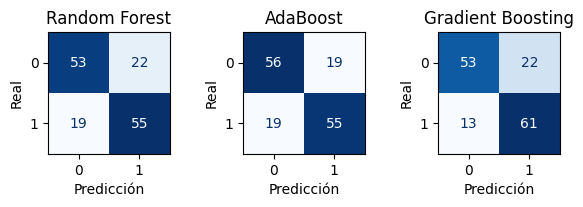

In [ ]:
# Mostrar matrices de confusión para todos los modelos en una sola figura
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Crear figura con 1 fila y 3 columnas
fig, axes = plt.subplots(1, 3, figsize=(6, 2))

for ax, (name, mp) in zip(axes, models_params.items()):
    model = mp["model"].set_params(**rows[[r["Model"] for r in rows].index(name)]["Best Params"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(name)
    ax.set_xlabel('Predicción')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


|                      | **Predicho: 0 (Sano)** | **Predicho: 1 (Enfermo)** |
|----------------------|------------------------|----------------------------|
| **Real: 0 (Sano)**   | **TP (Verdaderos Negativos)** | **FP (Falsos Positivos)** |
| **Real: 1 (Enfermo)**| **FN (Falsos Negativos)**     | **TP (Verdaderos Positivos)** |

Visualización comparativa de métricas

In [33]:
# Seleccionar columnas relevantes
metrics_df = pd.DataFrame(rows)[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]
metrics_df.set_index('Model', inplace=True)

# Función para resaltar el valor máximo en cada columna
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: darkblue' if v else '' for v in is_max]

# Mostrar con estilos
styled_table = metrics_df.style.apply(highlight_max, axis=0).format("{:.3f}")
styled_table

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,0.725,0.714,0.743,0.728
AdaBoost,0.745,0.743,0.743,0.743
Gradient Boosting,0.765,0.735,0.824,0.777


In [ ]:
# Análisis automático del mejor modelo basado en métricas clave

# Crear DataFrame con resultados
df_metrics = pd.DataFrame(rows)

# Evaluar por F1-Score como métrica global de equilibrio entre precisión y recall
best_model = df_metrics.loc[df_metrics['F1-Score'].idxmax()]

# Mostrar resumen claro
print("🔍 Evaluación comparativa de modelos:")
print(df_metrics[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']])
print("\nMejor modelo general:")

print(f"Modelo: {best_model['Model']}")
print(f"F1-Score: {best_model['F1-Score']:.3f}")
print(f"Precision: {best_model['Precision']:.3f}")
print(f"Recall: {best_model['Recall']:.3f}")
print(f"ROC AUC: {best_model['ROC AUC']:.3f}")
print(f"Accuracy: {best_model['Accuracy']:.3f}")

# Justificación textual
print(f"\n✅ El modelo {best_model['Model']} ha sido seleccionado como el mejor modelo general porque presenta el F1-Score más alto ({best_model['F1-Score']:.3f}),")
print(f"lo que indica un equilibrio sólido entre precisión ({best_model['Precision']:.3f}) y recall ({best_model['Recall']:.3f}).")
print(f"También destaca con un ROC AUC de {best_model['ROC AUC']:.3f}, lo que sugiere una excelente capacidad de discriminación.")


🔍 Evaluación comparativa de modelos:
               Model  Accuracy  Precision    Recall  F1-Score   ROC AUC
0      Random Forest  0.724832   0.714286  0.743243  0.728477  0.814595
1           AdaBoost  0.744966   0.743243  0.743243  0.743243  0.783514
2  Gradient Boosting  0.765101   0.734940  0.824324  0.777070  0.810000

Mejor modelo general:
Modelo: Gradient Boosting
F1-Score: 0.777
Precision: 0.735
Recall: 0.824
ROC AUC: 0.810
Accuracy: 0.765

✅ El modelo Gradient Boosting ha sido seleccionado como el mejor modelo general porque presenta el F1-Score más alto (0.777),
lo que indica un equilibrio sólido entre precisión (0.735) y recall (0.824).
También destaca con un ROC AUC de 0.810, lo que sugiere una excelente capacidad de discriminación.


#### ✅ El modelo Gradient Boosting ha sido seleccionado como el mejor modelo general porque presenta el F1-Score más alto (0.777),


In [52]:
# Expandir el ancho de columnas en la salida de pandas
pd.set_option('display.max_colwidth', None)


# Mostrar solo el Best Model
best_model_name = best_model['Model']
results_df[results_df['Model'] == best_model_name]

,Model,ROC AUC,Accuracy,Precision,Recall,F1-Score,Best Params
2,Gradient Boosting,0.81,0.765101,0.73494,0.824324,0.77707,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}"


Importancia de las características del mejor modelo - Gradient Boosting


📊 Importancia de las características: (Gradient Boosting)
chest_pain_type: 0.4765
age: 0.1849
max_heart_rate: 0.1019
sex: 0.0904
cholesterol: 0.0650
resting_bp_s: 0.0495
fasting_blood_sugar: 0.0243
resting_ecg: 0.0075


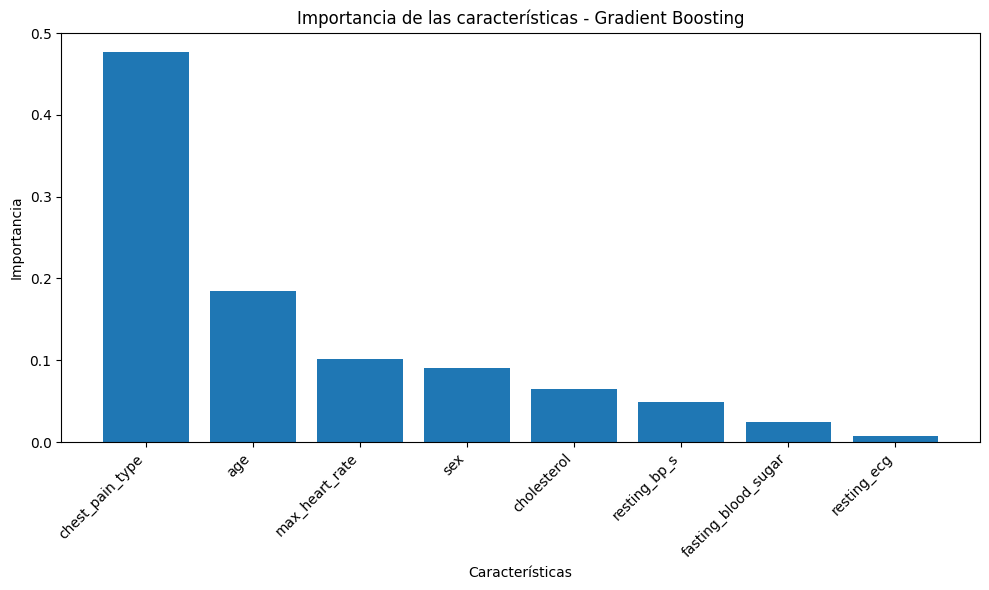

In [ ]:
# Mostrar la importancia de las características del mejor modelo
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Mapear nombres a clases
model_mapping = {
    "Random Forest": RandomForestClassifier,
    "AdaBoost": AdaBoostClassifier,
    "Gradient Boosting": GradientBoostingClassifier
}

# Inicializar el modelo correcto con los mejores parámetros
best_params = results_df[results_df["Model"] == best_model_name]["Best Params"].values[0]
ModelClass = model_mapping[best_model_name]
model = ModelClass(**best_params, random_state=42)

# Entrenar con todos los datos de entrenamiento
model.fit(X_train, y_train)

# Obtener importancias (solo si el modelo tiene feature_importances_)
if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    features = X.columns
    indices = np.argsort(importances)[::-1]

    print(f"\n📊 Importancia de las características: ({best_model_name})")
    for i in indices:
        print(f"{features[i]}: {importances[i]:.4f}")

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.title(f"Importancia de las características - {best_model_name}")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), features[indices], rotation=45, ha='right')
    plt.xlabel("Características")
    plt.ylabel("Importancia")
    plt.tight_layout()
    plt.show()
else:
    print(f"⚠️ El modelo '{best_model_name}' no tiene atributo 'feature_importances_'.")
    


.

## Evaluar el rendimiento del modelo por sexo

Obserbamos que datos de 'sex' están desbalanceados:
+ 75,6 (1) Hombres 
+ 24,4 (0) Mujeres 

Evaluamos el rendimiento del modelo por sexo.

In [215]:
df_heart['sex'].value_counts()

sex
1.0    562
0.0    181
Name: count, dtype: int64

In [216]:
print(f"\n📊 Distribución en '{'sex'}':")
print(df_heart['sex'].value_counts(normalize=True).mul(100).round(1))


📊 Distribución en 'sex':
sex
1.0    75.6
0.0    24.4
Name: proportion, dtype: float64


#### Evaluar métricas por subgrupo (sex)

In [217]:
# Separa X y y:
X = df_heart.drop(columns=['target'])
y = df_heart['target']

# Guardar la columna 'sex' antes de escalar, para luego análisis por grupo
sex_raw = X['sex']


In [218]:
# Paso 1 - train_test_split, añade esto para dividir también sex_raw:
X_train_raw, X_test_raw, y_train, y_test, sex_train, sex_test = train_test_split(
    X, y, sex_raw, test_size=0.2, random_state=42
)

# Escalar después de dividir
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


In [219]:
# Paso 2 - Entrenar el modelo con los mejores parámetros encontrados

# Extraer los mejores parámetros del mejor modelo
best_params = results_df[results_df["Model"] == best_model_name]["Best Params"].values[0]

# Crear y entrenar el modelo dinámicamente
ModelClass = model_mapping[best_model_name]
model = ModelClass(**best_params, random_state=42)
model.fit(X_train, y_train)


,loss,'log_loss'
,learning_rate,0.05
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [220]:
# Paso 3 – Predecir sobre X_test
y_pred = model.predict(X_test)

# predict_proba
y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

In [221]:
# Reporte de clasificación completo
report = classification_report(y_test, y_pred, output_dict=True)

# Buscar clave real de la clase positiva
target_label = next((key for key in report if key in ("1.0", "1")), None)
class_1_metrics = report.get(target_label, {"precision": 0, "recall": 0, "f1-score": 0})

# Crear resumen de métricas
row = {
    "Model": best_model_name,
    "ROC AUC": roc_auc_score(y_test, y_proba) if y_proba is not None else None,
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": class_1_metrics["precision"],
    "Recall": class_1_metrics["recall"],
    "F1-Score": class_1_metrics["f1-score"],
    "Best Params": best_params
}

# Mostrar resultados en DataFrame
summary_df = pd.DataFrame([row])
summary_df


,Model,ROC AUC,Accuracy,Precision,Recall,F1-Score,Best Params
0,Gradient Boosting,0.81,0.765101,0.73494,0.824324,0.77707,"{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}"


In [222]:
# Crear máscaras por sexo
mask_male = sex_test == 1
mask_female = sex_test == 0

# Diccionario para guardar reportes por grupo
group_reports = {}

# Evaluar por subgrupo
for label, mask in [("Hombres (1)", mask_male), ("Mujeres (0)", mask_female)]:
    y_true, y_hat = y_test[mask], y_pred[mask]
    print(f"\n📋 Resultados para {label}:")
    print(f"Total muestras: {mask.sum()}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_hat))
    print("Reporte de clasificación:")
    report = classification_report(y_true, y_hat)
    print(report)

    # Guardar reporte en dict por si lo necesitas
    group_reports[label] = classification_report(y_true, y_hat, output_dict=True)



📋 Resultados para Hombres (1):
Total muestras: 122
Matriz de confusión:
[[36 18]
 [11 57]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.77      0.67      0.71        54
         1.0       0.76      0.84      0.80        68

    accuracy                           0.76       122
   macro avg       0.76      0.75      0.76       122
weighted avg       0.76      0.76      0.76       122


📋 Resultados para Mujeres (0):
Total muestras: 27
Matriz de confusión:
[[17  4]
 [ 2  4]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        21
         1.0       0.50      0.67      0.57         6

    accuracy                           0.78        27
   macro avg       0.70      0.74      0.71        27
weighted avg       0.81      0.78      0.79        27



[[TN FP]

[FN TP]]

#### Teniendo en cuenta los resultados y los pocos datos de mujers, procedemos a generar datos sintéticos de mujeres.
#### Utilizamos MOSTLY AI para generar los datos con el mismo porcentaje de target 


_

### NUEVO ENTRENAMIENTO CON NUEVO DATASET BALANCEADO POR SEXO 

#### Subida de fichero heart_females_synthetic.csv con los datos sintéticos al bucket de GCP.

In [277]:
upload_csv_to_bucket(
    bucket_name="mi-bucket-heartdata",
    source_file_path="../../data/synthetic/heart_females_synthetic.csv",
    destination_blob_name="data/synthetic_500_women.csv"
)

Archivo ../../data/synthetic/heart_females_synthetic.csv subido a gs://mi-bucket-heartdata/data/synthetic_500_women.csv


Carga del archivo con los datos sintéticos desde GCS 

In [280]:
bucket_name = "mi-bucket-heartdata"
blob_path = "data/synthetic_500_women.csv"
file_path = f"gs://{bucket_name}/{blob_path}"

In [281]:
# Cargar el CSV de mujeres sintéticas desde GCS
df_synthetic_500 = pd.read_csv(file_path)
df_synthetic_500.head()

,age,sex,chest_pain_type,resting_bp_s,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,target
0,35,0.0,3.0,100,40,0.0,0.0,159,1.0
1,53,0.0,3.0,130,344,0.0,0.0,150,0.0
2,35,0.0,4.0,180,409,0.0,2.0,150,0.0
3,58,0.0,2.0,135,243,0.0,0.0,182,1.0
4,35,0.0,3.0,100,344,0.0,0.0,157,0.0


In [282]:
# Verificamos que sex = 0 en el sintético
print("Valores únicos en 'sex' (sintético):", df_synthetic_500['sex'].unique())

Valores únicos en 'sex' (sintético): [0.]


In [283]:
df_synthetic_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  500 non-null    int64  
 1   sex                  500 non-null    float64
 2   chest_pain_type      500 non-null    float64
 3   resting_bp_s         500 non-null    int64  
 4   cholesterol          500 non-null    int64  
 5   fasting_blood_sugar  500 non-null    float64
 6   resting_ecg          500 non-null    float64
 7   max_heart_rate       500 non-null    int64  
 8   target               500 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 35.3 KB


In [284]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 743 entries, 0 to 1189
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  743 non-null    float64
 1   sex                  743 non-null    float64
 2   chest_pain_type      743 non-null    float64
 3   resting_bp_s         743 non-null    float64
 4   cholesterol          743 non-null    float64
 5   fasting_blood_sugar  743 non-null    float64
 6   resting_ecg          743 non-null    float64
 7   max_heart_rate       743 non-null    float64
 8   target               743 non-null    float64
dtypes: float64(9)
memory usage: 58.0 KB


In [285]:
# Convertir todas las columnas a float64 en el dataset sintético
df_synthetic_500 = df_synthetic_500.astype('float64')

In [286]:
df_synthetic_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  500 non-null    float64
 1   sex                  500 non-null    float64
 2   chest_pain_type      500 non-null    float64
 3   resting_bp_s         500 non-null    float64
 4   cholesterol          500 non-null    float64
 5   fasting_blood_sugar  500 non-null    float64
 6   resting_ecg          500 non-null    float64
 7   max_heart_rate       500 non-null    float64
 8   target               500 non-null    float64
dtypes: float64(9)
memory usage: 35.3 KB


In [287]:
df_synthetic_500['sex'].value_counts()

sex
0.0    500
Name: count, dtype: int64

In [288]:
# Paso 1 – Filtrar por target
df_synthetic_0 = df_synthetic_500[df_synthetic_500['target'] == 0]
df_synthetic_1 = df_synthetic_500[df_synthetic_500['target'] == 1]

# Paso 2 – Calcular cuántos de cada clase (75% clase 0, 25% clase 1)
n_total = 250
n_0 = int(n_total * 0.75)  # 187
n_1 = n_total - n_0        # 63

# Paso 3 – Muestrear aleatoriamente sin reemplazo
sampled_0 = df_synthetic_0.sample(n=n_0, random_state=42)
sampled_1 = df_synthetic_1.sample(n=n_1, random_state=42)

# Paso 4 – Unir y barajar
df_synthetic_balanced = pd.concat([sampled_0, sampled_1]).sample(frac=1, random_state=42).reset_index(drop=True)


In [289]:
print(df_synthetic_balanced['target'].value_counts(normalize=True).round(2) * 100)


target
0.0    75.0
1.0    25.0
Name: proportion, dtype: float64


In [290]:
# Concatenar original + sintético
df_augmented = pd.concat([df_heart, df_synthetic_balanced], ignore_index=True)

print("\n✅ Dataset combinado:")
print("Original:", df_heart.shape)
print("Sintético:", df_synthetic_balanced.shape)
print("Total:", df_augmented.shape)


✅ Dataset combinado:
Original: (743, 9)
Sintético: (250, 9)
Total: (993, 9)


In [291]:
print(f"\n📊 Distribución en '{'sex'}':")
print(df_augmented['sex'].value_counts(normalize=True).mul(100).round(1))


📊 Distribución en 'sex':
sex
1.0    56.6
0.0    43.4
Name: proportion, dtype: float64


In [295]:
# Asegurarse de que exista la carpeta 'results'
output_path = project_root / "data/synthetic"
output_path.mkdir(parents=True, exist_ok=True)

# Guardar resultados
df_augmented.to_csv(output_path / "heart_disease_augmented.csv", index=False)
print("Archivo guardado en: data/synthetic/heart_disease_augmented.csv")


Archivo guardado en: data/synthetic/heart_disease_augmented.csv


#### Subida de fichero heart_disease_augmented.csv al bucket de GCP.

In [296]:
upload_csv_to_bucket(
    bucket_name="mi-bucket-heartdata",
    source_file_path="../../data/synthetic/heart_disease_augmented.csv",
    destination_blob_name="data/heart_disease_augmented.csv"
)

Archivo ../../data/synthetic/heart_disease_augmented.csv subido a gs://mi-bucket-heartdata/data/heart_disease_augmented.csv


### Reentrenar el modelo y comparar resultados por sexo

In [292]:
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import classification_report, confusion_matrix

# Separar variables
X = df_augmented.drop(columns=['target'])
y = df_augmented['target']
sex_raw = X['sex']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División del dataset (incluyendo sex)
X_train, X_test, y_train, y_test, sex_train, sex_test = train_test_split(
    X_scaled, y, sex_raw, test_size=0.2, random_state=42
)

# Extraer los mejores parámetros del mejor modelo
best_params = results_df[results_df["Model"] == best_model_name]["Best Params"].values[0]

# Crear y entrenar el modelo dinámicamente
ModelClass = model_mapping[best_model_name]
model = ModelClass(**best_params, random_state=42)
model.fit(X_train, y_train)


,loss,'log_loss'
,learning_rate,0.05
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [293]:
# Predicciones
y_pred = rf_model.predict(X_test)

#### Evaluación por sexo tras el aumento de datos

In [294]:
# Evaluar por grupo (mujeres y hombres)
mask_male = sex_test == 1
mask_female = sex_test == 0

for label, mask in [("Hombres (1)", mask_male), ("Mujeres (0)", mask_female)]:
    print(f"\n📋 Resultados para {label}:")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test[mask], y_pred[mask]))
    print("Reporte de clasificación:")
    print(classification_report(y_test[mask], y_pred[mask]))



📋 Resultados para Hombres (1):
Matriz de confusión:
[[34  9]
 [ 8 63]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80        43
         1.0       0.88      0.89      0.88        71

    accuracy                           0.85       114
   macro avg       0.84      0.84      0.84       114
weighted avg       0.85      0.85      0.85       114


📋 Resultados para Mujeres (0):
Matriz de confusión:
[[64  1]
 [10 10]]
Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92        65
         1.0       0.91      0.50      0.65        20

    accuracy                           0.87        85
   macro avg       0.89      0.74      0.78        85
weighted avg       0.88      0.87      0.86        85



|                      | **Predicho: 0 (Sano)** | **Predicho: 1 (Enfermo)** |
|----------------------|------------------------|----------------------------|
| **Real: 0 (Sano)**   | **TP (Verdaderos Negativos)** | **FP (Falsos Positivos)** |
| **Real: 1 (Enfermo)**| **FN (Falsos Negativos)**     | **TP (Verdaderos Positivos)** |

## Los resultados con 250 datos sintéticos de mujeres para balancear el dataframe
## df_heart mejoran las predicciones tanto de mujeres cómo de hombres.

#### 1. Comparativa por sexo

📈 Mejora notable en mujeres, sobre todo en f1-score (+0.08) y accuracy (+0.09).

👨‍🔬 En hombres también se observa mejora, posiblemente por regularización o mayor equilibrio general.

Hombres (sex = 1)

| Métrica            | Dataset original (`df_heart`) | Dataset aumentado (`df_augmented`) |
| ------------------ | ----------------------------- | ---------------------------------- |
| **Accuracy**       | 0.76                          | **0.85** ✅                         |
| **Precision (1)**  | 0.76                          | **0.88** ✅                         |
| **Recall (1)**     | 0.84                          | 0.89 ✅                             |
| **F1-Score (1)**   | 0.80                          | **0.88** ✅                         |
| **Total muestras** | 122                           | 114                                |

Mujeres (sex = 0)

| Métrica            | Dataset original (`df_heart`) | Dataset aumentado (`df_augmented`) |
| ------------------ | ----------------------------- | ---------------------------------- |
| **Accuracy**       | 0.78                          | **0.87** ✅                         |
| **Precision (1)**  | 0.50                          | **0.91** ✅                         |
| **Recall (1)**     | 0.67                          | 0.50 ❌ (ligera caída)              |
| **F1-Score (1)**   | 0.57                          | **0.65** ✅                         |
| **Total muestras** | 27                            | 85                                 |


#### 📘 2. Comparativa global (sin dividir por sexo)

🔍 Suben todas las métricas globales, demostrando que:

El dataset extendido mejora la generalización.

Los nuevos datos no introducen ruido ni sesgo.

| Dataset            | Accuracy | Precision | Recall | F1-Score |
| ------------------ | -------- | --------- | ------ | -------- |
| Original           | 0.78     | 0.72      | 0.76   | 0.74     |
| Con 250 sintéticos | 0.86     | 0.87      | 0.77   | 0.81     |

